# Siamese Neural Network — Trade Matching Pipeline

This notebook implements an end-to-end **learning-to-rank** pipeline using a **Siamese neural network** to match financial trades across systems.

**Pipeline Steps:**
1. **Environment & Imports** — Detect runtime (Local / Databricks) and load project modules
2. **Configuration** — Define column mappings and candidate retrieval thresholds
3. **Data Loading & Cleaning** — Load trade data, filter to valid matched pairs
4. **Train / Val / Test Split** — Stratified group split to prevent data leakage
5. **Episode Construction** — Build training episodes with hard-negative mining
6. **TF-IDF Vectorisation** — Fit character n-gram vectorizer on training text
7. **Model Initialisation** — Create Siamese network, dataset wrappers, and data loaders
8. **Training Loop** — Train with listwise cross-entropy and early stopping
9. **Evaluation** — Test set performance and analysis visuals

Each section includes artifact inspection so you can verify intermediate outputs.

## Step 1 — Environment & Imports

Detect whether we're running locally or in Databricks, set up `sys.path` so Python can find our project modules, then import all pipeline components.

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# --- Detect runtime environment ---
IN_DATABRICKS = "DATABRICKS_RUNTIME_VERSION" in os.environ

# --- Setup Paths ---
if IN_DATABRICKS:
    # In Databricks Repos the working dir is the repo root
    project_root = os.getcwd()
else:
    current_dir = os.getcwd()
    if current_dir.endswith("notebooks"):
        project_root = os.path.abspath(os.path.join(current_dir, "../../../.."))
    elif os.path.exists("src"):
        project_root = current_dir
    else:
        project_root = current_dir

if project_root not in sys.path:
    sys.path.append(project_root)

print(f"Project Root: {project_root}")
print(f"Environment:  {'Databricks' if IN_DATABRICKS else 'Local'}")

# --- Project Imports ---
from src.model.nn_matching.pipeline.data_prep import (
    normalize, normalize_and_combine, rebuild_combined_text_for_row,
    add_date_int_cols, stratified_group_split_3way,
)
from src.model.nn_matching.pipeline.candidate_generation import (
    get_candidates,
    build_training_episodes_single_df_debug,
    build_training_episodes_parallel,
    build_training_episodes_sequential,
    build_training_episodes_spark,
)
from src.model.nn_matching.pipeline.vectorization import (
    iter_episode_text, vectorize_episode
)
from src.model.nn_matching.models.siamese_network import (
    SiameseMatchingNet, RankingEpisodeDataset, collate_episodes_flat
)
from src.model.nn_matching.models.losses import (
    listwise_ce_from_groups, batch_metrics_from_logits
)
from torch.utils.data import DataLoader

## Step 2 — Configuration

Define the column names that map to your dataset and the thresholds for candidate retrieval (blocking). These control how hard-negatives are selected during episode construction.

| Parameter | Purpose |
|-----------|---------|
| `WINDOW_DAYS` | Maximum date difference (days) between query and candidate |
| `AMOUNT_TOL_PCT` | Maximum relative amount difference (30% = 0.30) |
| `TOP_K` | Max candidates returned per query |
| `TRAIN_K_NEG` | Negatives per training episode |

In [ ]:
# Column names and matching parameters — adjust these per dataset
ID_COL = "Trade Id"
REF_COL = None
DATE_COLS = ["Trade Date", "Trade Maturity Date", "Trade Value Date"]
DATE_INT_COLS = [f"{c}_int" for c in DATE_COLS]
EPOCH = pd.Timestamp("1970-01-01")

AMOUNT_COL = "GBP_Absolute"
CURRENCY_COL = "Transactional Currency"

# Candidate retrieval thresholds
WINDOW_DAYS = 20
AMOUNT_TOL_PCT = 0.30
TOP_K = 50
TRAIN_K_NEG = 10
ENFORCE_SAME_SIGN = False
DATE_POLICY = "any"
timing_stats = defaultdict(float)

## Step 3 — Data Loading & Cleaning

Load the trade dataset, filter to valid matched pairs (1-to-1 only), and prepare for splitting. The filtering pipeline:

**Raw data → matched trades only → allowed match rules → valid Match IDs → group size = 2 (1-to-1 pairs)**

This ensures we only train on clean, unambiguous match pairs where each trade has exactly one counterpart.

In [ ]:
# Load private config (column lists, filtering rules). Falls back to empty if missing.
try:
    from private_config import COMMENTS, MATCH_RULE, MATCH_ID, example_data, COLUMNS_TO_SELECT
except ImportError:
    print("Warning: private_config.py not found. Please ensure the file is present.")
    COMMENTS = []
    MATCH_RULE = []
    MATCH_ID = []
    example_data = []
    COLUMNS_TO_SELECT = []

In [ ]:
# Import synthetic data generator (private, gitignored)
try:
    from private_data_generation import generate_synthetic_data
except ImportError:
    print("Warning: private_data_generation.py not found.")
    def generate_synthetic_data(*args, **kwargs):
        raise NotImplementedError("Synthetic data generation code is missing.")

In [ ]:
# Generate synthetic data and sanity-check a few matched pairs
df_synth = generate_synthetic_data(n_rows=5000, overwrite=True)
print(f"Generated shape: {df_synth.shape}")

matched_subset = df_synth[df_synth["matched"]].sort_values("Match ID").head(4)
display(matched_subset[["Trade Id", "Match ID", "Comments", "Match Rule", "Transactional Currency", "GBP Currency Amount", "Trade Date"]])

Generated shape: (50, 48)
Sample matched pairs:


,Trade Id,Match ID,Comments,Match Rule,Transactional Currency,GBP Currency Amount,Trade Date
22,T000000023,17911-7794_0,Offsetting Trades,ISIN,HKD,276443.763788,2025-03-08
21,T000000022,17911-7794_0,Offsetting Trades,ISIN,HKD,-276443.763788,2025-03-08
13,T000000014,18971-2827_12,Matched by Derivative Netting,Trade Id ending with GS/SG,EUR,765298.829899,2025-10-05
14,T000000015,18971-2827_12,Matched by Derivative Netting,Trade Id ending with GS/SG,EUR,-765298.829899,2025-10-05


In [ ]:
# Load data — tries parquet first, falls back to CSV, then generates if needed
DATA_FILENAME = "synthetic_derivatives_data.parquet"

if IN_DATABRICKS:
    # In Databricks Repos the file lives at /Workspace/Repos/<user>/<repo>/
    DATA_PATH = os.path.join(project_root, DATA_FILENAME)
else:
    DATA_PATH = os.path.join(project_root, DATA_FILENAME)

if os.path.exists(DATA_PATH):
    try:
        df = pd.read_parquet(DATA_PATH)
    except:
        df = pd.read_csv(DATA_PATH.replace(".parquet", ".csv"))
else:
    csv_path = DATA_PATH.replace(".parquet", ".csv")
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
    elif os.path.exists(DATA_FILENAME.replace(".parquet", ".csv")):
        df = pd.read_csv(DATA_FILENAME.replace(".parquet", ".csv"))
    else:
        print(f"Data not found at {DATA_PATH}, generating new...")
        df = generate_synthetic_data(1000)

display(df.head(200))

,Business Date,TETB FISS Number,Acct Ico Match Level 3 Name,FLEX Balance Source,Master Book Code,Username,Racc MU,Reporting Party MCU Code,Sap Cost Centre,Sap Acct Description,...,Reporting Party SU,PDC SU,Relationship,GBP Currency Amount,GBP_Absolute,matched,Match Type,Comments,Match Rule,Match ID
0,2025-02-02,212814952,I/C BSd Derivatives,MOTIF,517217,No Data,M620,20853,13878-3819,Intl Dr-B Book Deriv,...,None,None,None,1.481480e+06,1.481480e+06,True,Matched with differences,Matched by Derived Trade Id,Adb Adjustment Text,ldn057de2ff_470
1,2025-10-10,NaN,I/C BSd Derivatives,GBS,827469,Sri Varun Satuluri,M635,41981,48238-7750,Intl Dr-B Book Deriv,...,None,None,None,6.376945e+05,6.376945e+05,False,Exact Match,Unmatched,Unmatched,NaN
2,2025-08-27,212814952,I/C BSd Derivatives,MOTIF,517217,No Data,M620,20853,13878-3819,Intl Dr-B Book Deriv,...,None,None,None,5.731204e+05,5.731204e+05,False,Matched with differences,Unmatched,Unmatched,NaN
3,2025-11-29,NaN,I/C BSd Derivatives,GBS,827469,Sri Varun Satuluri,M635,41981,48238-7750,Intl Dr-B Book Deriv,...,None,None,None,-8.469405e+05,8.469405e+05,True,Exact Match,Matched by Derivative Netting,B-B1,Zero Value_570
4,2025-06-08,NaN,I/C BSd Derivatives,GBS,827469,Sri Varun Satuluri,M635,41981,48238-7750,Intl Dr-B Book Deriv,...,None,None,None,1.494277e+06,1.494277e+06,True,Exact Match,Matched by Derivative Netting,Sub Ledger Account + Absolute of Transactional...,ldn057f4f4b_498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2025-02-01,NaN,I/C BSd Derivatives,GBS,838583,No Data,M635,43423,25940-7750,Intl Cr-B Book Deriv,...,None,None,None,2.164115e+05,2.164115e+05,True,Exact Match,OTC Payment Control Account,Trade Maturity Date + |abs(Leg1)| + abs(Leg2)|...,2013-01-25_2014-09-17_EUR_112
196,2025-07-10,NaN,I/C BSd Derivatives,GBS,838583,No Data,M635,43423,25940-7750,Intl Cr-B Book Deriv,...,None,None,None,-1.159547e+06,1.159547e+06,True,Exact Match,FlexRep SAP,Offsetting Trade Id,ESHLA BUK late fee posting 24660833B (Charms I...
197,2025-02-13,NaN,I/C BSd Derivatives,GBS,838583,No Data,M635,43423,25940-7750,Intl Cr-B Book Deriv,...,None,None,None,1.200921e+05,1.200921e+05,False,Exact Match,Unmatched,Unmatched,NaN
198,2025-05-04,212814952,I/C BSd Derivatives,MOTIF,517217,No Data,M620,20853,13878-3819,Intl Dr-B Book Deriv,...,None,None,None,1.375898e+06,1.375898e+06,False,Matched with differences,Unmatched,Unmatched,NaN


In [ ]:
# Keep only the columns needed for matching
df_clean = df[COLUMNS_TO_SELECT]
df_clean.head(5)

,Business Date,TETB FISS Number,Acct Ico Match Level 3 Name,FLEX Balance Source,Master Book Code,Username,Racc MU,Reporting Party MCU Code,Sap Cost Centre,Sap Acct Description,...,Reporting Party SU,PDC SU,Relationship,GBP Currency Amount,GBP_Absolute,matched,Match Type,Comments,Match Rule,Match ID
0,2025-02-02,212814952,I/C BSd Derivatives,MOTIF,517217,No Data,M620,20853,13878-3819,Intl Dr-B Book Deriv,...,None,None,None,1.481480e+06,1.481480e+06,True,Matched with differences,Matched by Derived Trade Id,Adb Adjustment Text,ldn057de2ff_470
1,2025-10-10,NaN,I/C BSd Derivatives,GBS,827469,Sri Varun Satuluri,M635,41981,48238-7750,Intl Dr-B Book Deriv,...,None,None,None,6.376945e+05,6.376945e+05,False,Exact Match,Unmatched,Unmatched,NaN
2,2025-08-27,212814952,I/C BSd Derivatives,MOTIF,517217,No Data,M620,20853,13878-3819,Intl Dr-B Book Deriv,...,None,None,None,5.731204e+05,5.731204e+05,False,Matched with differences,Unmatched,Unmatched,NaN
3,2025-11-29,NaN,I/C BSd Derivatives,GBS,827469,Sri Varun Satuluri,M635,41981,48238-7750,Intl Dr-B Book Deriv,...,None,None,None,-8.469405e+05,8.469405e+05,True,Exact Match,Matched by Derivative Netting,B-B1,Zero Value_570
4,2025-06-08,NaN,I/C BSd Derivatives,GBS,827469,Sri Varun Satuluri,M635,41981,48238-7750,Intl Dr-B Book Deriv,...,None,None,None,1.494277e+06,1.494277e+06,True,Exact Match,Matched by Derivative Netting,Sub Ledger Account + Absolute of Transactional...,ldn057f4f4b_498


In [ ]:
# Filter to matched trades with valid Match IDs, then keep only 1-to-1 pairs (group size == 2)
df_matched   = df_clean[df_clean["matched"] == True].copy().reset_index(drop=True)
df_unmatched = df_clean[df_clean["matched"] == False].copy().reset_index(drop=True)

print(f"Matched pool           : {len(df_matched):,} rows")
print(f"Unmatched (holdout): {len(df_unmatched):,} rows")

# 1) Filter by allowed match types and valid Match IDs
allowed = {
    "FX Revaluation",
    "Matched by Derived Trade Id",
    "Matched by Instrument Identifier and Trade Economics",
}

n0 = len(df_matched)

mask_comments  = df_matched["Comments"].isin(allowed)
mask_notna     = df_matched["Match ID"].notna()
mask_not_blank = df_matched["Match ID"].astype(str).str.strip() != ""
mask_not_ref   = df_matched["Match ID"].astype(str) != "#REF!"

mask_valid_id = mask_notna & mask_not_blank & mask_not_ref

drop_not_allowed = (~mask_comments).sum()
drop_bad_match_id = (mask_comments & ~mask_valid_id).sum()

df_m_rules = df_matched.loc[mask_comments].copy()
df_m_valid = df_matched.loc[mask_comments & mask_valid_id].copy()

n_rules = len(df_m_rules)
n_valid = len(df_m_valid)

print("\n=== Matched stream | rule & Match ID filtering ===")
print(f"Rows before filtering (matched) : {n0:,}")
print(f"- dropped (Comments not allowed): {drop_not_allowed:,}")
print(f"- remaining after Comments filter: {n_rules:,}")
print(f"- dropped (invalid Match ID): {drop_bad_match_id:,}")
print(f"Rows after Comments+ID filters: {n_valid:,}")

# 2) Keep only 1-to-1 matches (exactly 2 rows per Match ID)
vc = df_m_valid["Match ID"].value_counts()

ids_size_1 = vc[vc == 1].index
ids_size_2 = vc[vc == 2].index
ids_size_3 = vc[vc == 3].index
ids_size_4 = vc[vc == 4].index
ids_size_5p = vc[vc >= 5].index

df_matched_1to1 = df_m_valid[df_m_valid["Match ID"].isin(ids_size_2)].copy()

n_rows_kept = len(df_matched_1to1)
n_ids_total = vc.shape[0]

print("\n=== 1-to-1 selection (group size == 2) ===")
print(f"Unique Match IDs after filters: {n_ids_total:,}")
print(f"- IDs with size=1: {len(ids_size_1):,}")
print(f"- IDs with size=2 (KEPT): {len(ids_size_2):,}")
print(f"- IDs with size=3: {len(ids_size_3):,}")
print(f"- IDs with size=4: {len(ids_size_4):,}")
print(f"- IDs with size>=5: {len(ids_size_5p):,}")
print(f"Rows KEPT in 1-to-1 set: {n_rows_kept:,} (should be 2 * #IDs kept)")

freq_of_freq = vc.value_counts().sort_index()
print("\nFull size distribution (cluster size -> number of Match IDs):")
print(freq_of_freq)

# 3) Per-rule summary
by_rule_before = (
    df_m_valid.groupby("Comments")["Match ID"]
    .nunique()
    .rename("Unique Match IDs (after Comments+ID filters)")
    .sort_values(ascending=False)
)

by_rule_after = (
    df_matched_1to1.groupby("Comments")["Match ID"]
    .nunique()
    .rename("Unique Match IDs kept (size=2)")
    .sort_values(ascending=False)
)

print("\n=== Per-Comments unique Match IDs (before vs kept) ===")
per_rule = pd.concat([by_rule_before, by_rule_after], axis=1).fillna(0).astype(int)
print(per_rule)

rows_by_rule_before = (
    df_m_valid["Comments"].value_counts().rename("Rows after Comments+ID filters")
)
rows_by_rule_after = (
    df_matched_1to1["Comments"].value_counts().rename("Rows kept (1-to-1)")
)

print("\n=== Per-Comments row counts (before vs kept) ===")
rows_rule = pd.concat([rows_by_rule_before, rows_by_rule_after], axis=1).fillna(0).astype(int)
print(rows_rule)

# 4) Final artefacts
print("\n=== Final artifacts ===")
print(f"Unmatched (holdout) rows: {len(df_unmatched):,}")
print(
    f"Matched 1-to-1 rows     : {len(df_matched_1to1):,} "
    f"(unique Match IDs: {df_matched_1to1['Match ID'].nunique():,})"
)

Matched pool           : 608 rows
Unmatched (holdout): 392 rows

=== Matched stream | rule & Match ID filtering ===
Rows before filtering (matched) : 608
- dropped (Comments not allowed): 448
- remaining after Comments filter: 160
- dropped (invalid Match ID): 0
Rows after Comments+ID filters: 160

=== 1-to-1 selection (group size == 2) ===
Unique Match IDs after filters: 80
- IDs with size=1: 0
- IDs with size=2 (KEPT): 80
- IDs with size=3: 0
- IDs with size=4: 0
- IDs with size>=5: 0
Rows KEPT in 1-to-1 set: 160 (should be 2 * #IDs kept)

Full size distribution (cluster size -> number of Match IDs):
count
2    80
Name: count, dtype: int64

=== Per-Comments unique Match IDs (before vs kept) ===
                                                    Unique Match IDs (after Comments+ID filters)  \
Comments                                                                                           
Matched by Derived Trade Id                                                                   

In [ ]:
# Visual: Data filtering funnel and match-rule distribution
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Left: Filtering funnel
stages = ["Raw matched", "After rule filter", "After ID filter", "1-to-1 pairs"]
counts = [n0, n_rules, n_valid, n_rows_kept]
colors = ["#bbb", "#8cb4d9", "#4a90d9", "#2563eb"]
bars = axes[0].barh(stages[::-1], counts[::-1], color=colors[::-1], edgecolor="white")
for bar, c in zip(bars, counts[::-1]):
    axes[0].text(bar.get_width() + max(counts)*0.02, bar.get_y() + bar.get_height()/2,
                 f"{c:,}", va="center", fontsize=10, fontweight="bold")
axes[0].set_xlabel("Rows")
axes[0].set_title("Data Filtering Funnel")
axes[0].set_xlim(0, max(counts) * 1.25)

# Right: Match rule distribution (final 1-to-1 set)
rule_counts = df_matched_1to1["Comments"].value_counts()
axes[1].barh(rule_counts.index, rule_counts.values, color="#4a90d9", edgecolor="white")
for i, (v, name) in enumerate(zip(rule_counts.values, rule_counts.index)):
    axes[1].text(v + max(rule_counts.values)*0.02, i, f"{v:,}", va="center", fontsize=10)
axes[1].set_xlabel("Rows")
axes[1].set_title("Match Rules (1-to-1 pairs)")

plt.tight_layout()
plt.show()

## Step 4 — Train / Val / Test Split

Split by **Match ID groups** (not individual rows) to prevent data leakage — if two rows share a Match ID, both go into the same split. Uses stratification by match rule to ensure each split has a representative rule distribution.

| Split | Purpose | Typical size |
|-------|---------|--------------|
| **Train** (70%) | Fit model weights | Largest portion |
| **Val** (15%) | Early stopping & hyperparameter tuning | Monitor during training |
| **Test** (15%) | Final held-out evaluation | Never seen during training |

In [ ]:
# Text columns concatenated into combined_text for TF-IDF input
columns_to_normalize_reduced = [
    "Trade Id",
    "Alternate Trade Id", "Alternate Trade Id 2", "Deal ID",
    "Unique Instrument Identifier", "TETB FISS Number",
    "Instrument Name", "ISIN", "CUSIP", "SEDOL",
]

In [ ]:
# Split into train/val/test by Match ID groups (no leakage across splits)
if 'df_synth' in globals():
    df_clean = df_synth[df_synth["matched"]].copy()

    try:
        df_train, df_val, df_test = stratified_group_split_3way(
            df_clean, 
            group_col="Match ID", 
            strat_col="Comments",
            train_size=0.7, 
            val_size=0.15, 
            test_size=0.15, 
            random_state=42
        )
    except ValueError as e:
        print(f"Stratified split failed (small sample): {e}")
        print("Falling back to random group split.")
        
        groups = df_clean["Match ID"].unique()
        rng = np.random.default_rng(42)
        rng.shuffle(groups)
        
        n = len(groups)
        n_train = int(n * 0.7)
        n_val = int(n * 0.15)
        
        train_groups = set(groups[:n_train])
        val_groups = set(groups[n_train:n_train+n_val])
        test_groups = set(groups[n_train+n_val:])
        
        df_train = df_clean[df_clean["Match ID"].isin(train_groups)].copy()
        df_val = df_clean[df_clean["Match ID"].isin(val_groups)].copy()
        df_test = df_clean[df_clean["Match ID"].isin(test_groups)].copy()

    # Build combined_text before episode construction (required for TF-IDF)
    print("Creating combined_text column for train/val/test splits...")
    df_train = normalize_and_combine(df_train, columns_to_normalize_reduced)
    df_val = normalize_and_combine(df_val, columns_to_normalize_reduced)
    df_test = normalize_and_combine(df_test, columns_to_normalize_reduced)

    print(f"Splits created: Train={len(df_train)}, Val={len(df_val)}, Test={len(df_test)}")
else:
    print("Warning: df_synth not found. Run the data generation cell first.")

Stratified split failed (likely small sample size): The least populated classes in y have only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2. Classes with too few members are: [np.str_('FX Revaluation'), np.str_('Matched by Instrument Identifier')]
Falling back to random group split.
Creating combined_text column for train/val/test splits...
Splits created: Train=18, Val=4, Test=6


/var/folders/lm/mg395mvd36g3fsqg6gjxv4r40000gn/T/ipykernel_36300/2222165298.py:28: UserWarning: you are shuffling a 'StringArray' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  rng.shuffle(groups)


In [ ]:
# Visual: Split sizes and rule distribution across splits
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Left: Split sizes
split_names = ["Train", "Val", "Test"]
split_sizes = [len(df_train), len(df_val), len(df_test)]
colors = ["#2563eb", "#f59e0b", "#10b981"]
bars = axes[0].bar(split_names, split_sizes, color=colors, edgecolor="white", width=0.5)
for bar, s in zip(bars, split_sizes):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(split_sizes)*0.02,
                 f"{s:,}", ha="center", fontsize=11, fontweight="bold")
axes[0].set_ylabel("Rows")
axes[0].set_title("Split Sizes")
axes[0].set_ylim(0, max(split_sizes) * 1.2)

# Right: Rule distribution per split (stacked)
all_rules = sorted(set(df_train["Comments"].unique()) |
                   set(df_val["Comments"].unique()) |
                   set(df_test["Comments"].unique()))
x = np.arange(len(all_rules))
w = 0.25
for i, (name, df_split, color) in enumerate(zip(split_names, [df_train, df_val, df_test], colors)):
    counts = [len(df_split[df_split["Comments"] == r]) for r in all_rules]
    axes[1].bar(x + i*w, counts, w, label=name, color=color, edgecolor="white")

axes[1].set_xticks(x + w)
axes[1].set_xticklabels(all_rules, rotation=25, ha="right", fontsize=8)
axes[1].set_ylabel("Rows")
axes[1].set_title("Rule Distribution per Split")
axes[1].legend()

plt.tight_layout()
plt.show()

## Step 5 — Episode Construction

Each **episode** represents one learning-to-rank problem:
1. Pick a matched trade **B** (the positive answer)
2. Clone B into a **query A** with a synthetic Trade Id (prevents trivial matching)
3. Use **blocking** (currency → date window → amount tolerance) to retrieve hard-negative candidates
4. Assemble: `[positive B, negative₁, negative₂, …, negativeₖ]`

The model must learn to rank the positive above all negatives using shared identifiers and economics — not memorised Trade IDs.

> **Hard negatives** are candidates that pass the blocking filters (same currency, similar date and amount) but are NOT the correct match. They force the model to learn fine-grained distinctions.

In [ ]:
# Add integer date columns needed by the candidate retrieval logic
df_pool_train = add_date_int_cols(df_train, DATE_COLS)
df_pool_val   = add_date_int_cols(df_val, DATE_COLS)
df_pool_test  = add_date_int_cols(df_test, DATE_COLS)

# Shared config for the episode builder
_episode_kwargs = dict(
    id_col=ID_COL,
    currency_col=CURRENCY_COL,
    amount_col=AMOUNT_COL,
    date_int_cols=DATE_INT_COLS,
    columns_to_normalize=columns_to_normalize_reduced,
    ref_col=REF_COL,
    train_k_neg=20,
    rule_col="Match Rule",
    enforce_same_sign=True,
    window_days=WINDOW_DAYS,
    amount_tol_pct=AMOUNT_TOL_PCT,
    date_policy=DATE_POLICY,
)

# Pick the right builder for the current environment:
#   Databricks  → Spark-distributed (falls back to sequential if Spark unavailable)
#   Local       → ProcessPoolExecutor parallel
if IN_DATABRICKS:
    _builder = build_training_episodes_spark
else:
    _builder = build_training_episodes_parallel

print(f"Using builder: {_builder.__name__}")

episodes_train, candidates_train_long_df = _builder(
    df_pool=df_pool_train, n_episodes=500, random_state=42, **_episode_kwargs,
)

episodes_val, candidates_val_long_df = _builder(
    df_pool=df_pool_val, n_episodes=min(100, len(df_pool_val)), random_state=4242, **_episode_kwargs,
)

episodes_test, candidates_test_long_df = _builder(
    df_pool=df_pool_test, n_episodes=min(100, len(df_pool_test)), random_state=424242, **_episode_kwargs,
)

print(f"\nEpisodes: train={len(episodes_train)}, val={len(episodes_val)}, test={len(episodes_test)}")


[15:41:14] ==== EPISODE 1 ====
[15:41:14] true_id=T000000046 | rule=Sub Ledger Account + Absolute of Transactional Currency
[15:41:14] a_id=Q::T000000046::e54432904b9946eda89de4523fd01117
[15:41:14] Query combined_text (first 80 chars): q t000000046 e54432904b9946eda89de4523fd01117 2060762 s0492e4b 95r81y4 212814952
[15:41:14] Positive combined_text (first 80 chars): t000000046 2060762 s0492e4b 95r81y4 212814952 95r81y4
[15:41:14] CALL get_candidates(top_k=40, window_days=20, amount_tol_pct=0.3, date_policy=any, enforce_same_sign=True) | currency=GBP
[15:41:14] neg_cands shape=(2, 58); columns=['Business Date', 'TETB FISS Number', 'Acct Ico Match Level 3 Name', 'FLEX Balance Source', 'Master Book Code', 'Username', 'Racc MU', 'Reporting Party MCU Code', 'Sap Cost Centre', 'Sap Acct Description', 'Sap Partner Profit Centre', 'Transactional Currency', 'GBP Currency Amount (for Balance Sheet Only)', 'Trade Id', 'Alternate Trade Id', 'Alternate Trade Id 2', 'Deal ID', 'Trade Link ID', 'Un

,AID,BID,rank,label,rule
0,Q::T000000046::e54432904b9946eda89de4523fd01117,T000000046,0,1,Sub Ledger Account + Absolute of Transactional...
1,Q::T000000046::e54432904b9946eda89de4523fd01117,T000000033,1,0,Sub Ledger Account + Absolute of Transactional...
2,Q::T000000046::e54432904b9946eda89de4523fd01117,T000000025,2,0,Sub Ledger Account + Absolute of Transactional...
3,Q::T000000046::e54432904b9946eda89de4523fd01117,T000000050,3,0,Sub Ledger Account + Absolute of Transactional...
4,Q::T000000046::e54432904b9946eda89de4523fd01117,T000000003,4,0,Sub Ledger Account + Absolute of Transactional...



[15:41:14] ==== EPISODE 1 ====
[15:41:14] true_id=T000000019 | rule=Trade Id ending with GS/SG
[15:41:14] a_id=Q::T000000019::4c48c6dacd15479d9bbf8f8e4eadce60
[15:41:14] Query combined_text (first 80 chars): q t000000019 4c48c6dacd15479d9bbf8f8e4eadce60 ldn067bb2d5 l4b9f93c
[15:41:14] Positive combined_text (first 80 chars): t000000019 ldn067bb2d5 l4b9f93c
[15:41:14] CALL get_candidates(top_k=40, window_days=20, amount_tol_pct=0.3, date_policy=any, enforce_same_sign=True) | currency=EUR
[15:41:14] neg_cands shape=(2, 58); columns=['Business Date', 'TETB FISS Number', 'Acct Ico Match Level 3 Name', 'FLEX Balance Source', 'Master Book Code', 'Username', 'Racc MU', 'Reporting Party MCU Code', 'Sap Cost Centre', 'Sap Acct Description', 'Sap Partner Profit Centre', 'Transactional Currency', 'GBP Currency Amount (for Balance Sheet Only)', 'Trade Id', 'Alternate Trade Id', 'Alternate Trade Id 2', 'Deal ID', 'Trade Link ID', 'Unique Instrument Identifier', 'ISIN', 'CUSIP', 'SEDOL', 'Trade Dat

In [ ]:
# Inspect: Episode structure and candidate distribution
if episodes_train:
    # Show one episode's structure
    ep = episodes_train[0]
    print("=== Episode 0 Structure ===")
    print(f"  Keys: {list(ep.keys())}")
    print(f"  Query ID:       {ep['query_id']}")
    print(f"  Match rule:     {ep['rule']}")
    print(f"  Positive index: {ep['positive_index']}")
    print(f"  Candidates:     {len(ep['candidates_df'])} rows")
    print(f"  Candidate IDs:  {ep['candidate_ids'][:5]}{'…' if len(ep['candidate_ids']) > 5 else ''}")

    # Distribution of candidates per episode
    cand_counts = [len(e["candidates_df"]) for e in episodes_train]
    fig, axes = plt.subplots(1, 2, figsize=(13, 4))

    axes[0].hist(cand_counts, bins=range(min(cand_counts), max(cand_counts)+2),
                 color="#4a90d9", edgecolor="white", alpha=0.9)
    axes[0].axvline(np.mean(cand_counts), color="red", ls="--", label=f"mean={np.mean(cand_counts):.1f}")
    axes[0].set_xlabel("Candidates per Episode")
    axes[0].set_ylabel("Count")
    axes[0].set_title("Candidate List Size Distribution (Train)")
    axes[0].legend()

    # Rule distribution in episodes
    rule_counts = pd.Series([e["rule"] for e in episodes_train]).value_counts()
    axes[1].barh(rule_counts.index, rule_counts.values, color="#4a90d9", edgecolor="white")
    for i, v in enumerate(rule_counts.values):
        axes[1].text(v + max(rule_counts.values)*0.02, i, str(v), va="center", fontsize=10)
    axes[1].set_xlabel("Episodes")
    axes[1].set_title("Episodes per Match Rule (Train)")

    plt.tight_layout()
    plt.show()

## Step 6 — TF-IDF Vectorisation

Fit a **character n-gram TF-IDF vectorizer** on training episode text only (no data leakage from val/test).

**Why character n-grams (2–4)?** Trade identifiers like ISINs, CUSIPs, and instrument names share sub-string patterns that word-level tokenisation would miss. Character n-grams capture partial matches (e.g., "US912" appears in many US treasury ISINs).

The vectorizer produces a sparse vector for each trade's `combined_text`. These become the text input (`t_a`, `t_b`) to the Siamese encoder.

In [ ]:
# Fit TF-IDF on training episodes only (char n-grams, no leakage)
vectorizer = TfidfVectorizer(
    analyzer="char_wb",
    ngram_range=(2, 4),
    dtype=np.float32,
)
vectorizer.fit(iter_episode_text(episodes_train))
VOCAB_SIZE = len(vectorizer.vocabulary_)
print(f"TF-IDF vocabulary size (train-only): {VOCAB_SIZE:,}")

✅ TF-IDF Vocab Size (train-only): 694


In [ ]:
# Inspect: TF-IDF vectorizer artifact
print("=== TF-IDF Vectorizer ===")
print(f"  Analyzer:      {vectorizer.analyzer}")
print(f"  N-gram range:  {vectorizer.ngram_range}")
print(f"  Vocabulary:    {VOCAB_SIZE:,} features")
print(f"  Dtype:         {vectorizer.dtype}")

# Sample vocabulary entries
vocab_items = sorted(vectorizer.vocabulary_.items(), key=lambda x: x[1])
print(f"\n  First 15 features:  {[v[0] for v in vocab_items[:15]]}")
print(f"  Last 15 features:   {[v[0] for v in vocab_items[-15:]]}")

# Show one vectorised example
if episodes_train:
    sample_text = episodes_train[0]["query_row"].get("combined_text", "")
    sample_vec = vectorizer.transform([sample_text]).toarray()[0]
    nonzero = np.count_nonzero(sample_vec)
    print(f"\n  Sample text:   '{sample_text[:80]}…'")
    print(f"  Vector shape:  {sample_vec.shape}")
    print(f"  Non-zero:      {nonzero} / {VOCAB_SIZE} ({100*nonzero/VOCAB_SIZE:.1f}%)")
    print(f"  Sparsity:      {100*(1 - nonzero/VOCAB_SIZE):.1f}%")

In [ ]:
# Visual: TF-IDF similarity distribution (positive vs negative pairs)
pos_sims, neg_sims = [], []

for ep in episodes_train[:200]:  # Sample first 200 episodes
    q_text = ep["query_row"].get("combined_text", "")
    cands = ep["candidates_df"]
    if cands is None or cands.empty or "combined_text" not in cands.columns:
        continue
    
    texts = [q_text] + cands["combined_text"].fillna("").tolist()
    vecs = vectorizer.transform(texts).toarray()
    
    for j in range(1, len(vecs)):
        sim = cosine_similarity(vecs[0:1], vecs[j:j+1])[0, 0]
        if j == 1:  # positive is always at index 0 in candidates
            pos_sims.append(sim)
        else:
            neg_sims.append(sim)

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Left: Histogram overlap
axes[0].hist(neg_sims, bins=40, alpha=0.6, label=f"Negatives (n={len(neg_sims):,})", color="#ef4444", density=True)
axes[0].hist(pos_sims, bins=40, alpha=0.7, label=f"Positives (n={len(pos_sims):,})", color="#22c55e", density=True)
axes[0].set_xlabel("TF-IDF Cosine Similarity")
axes[0].set_ylabel("Density")
axes[0].set_title("Query ↔ Candidate Similarity Distribution")
axes[0].legend()

# Right: Box plot comparison
axes[1].boxplot([pos_sims, neg_sims], labels=["Positive", "Negative"],
                patch_artist=True,
                boxprops=[dict(facecolor="#22c55e", alpha=0.7), dict(facecolor="#ef4444", alpha=0.7)])
axes[1].set_ylabel("TF-IDF Cosine Similarity")
axes[1].set_title("Similarity: Positive vs Negative")

plt.tight_layout()
plt.show()

print(f"Positive mean sim: {np.mean(pos_sims):.4f} ± {np.std(pos_sims):.4f}")
print(f"Negative mean sim: {np.mean(neg_sims):.4f} ± {np.std(neg_sims):.4f}")
print(f"Separation gap:    {np.mean(pos_sims) - np.mean(neg_sims):.4f}")

DIAGNOSTIC: Is Trade Id leaking into TF-IDF similarity?

📋 Columns in combined_text: ['Trade Id', 'Alternate Trade Id', 'Alternate Trade Id 2', 'Deal ID', 'Unique Instrument Identifier', 'TETB FISS Number', 'Instrument Name', 'ISIN', 'CUSIP', 'SEDOL']
   ⚠️  'Trade Id' is IN the list

📝 Query combined_text:
   'q t000000046 e54432904b9946eda89de4523fd01117 2060762 s0492e4b 95r81y4 212814952 95r81y4...'

📝 Positive (B) combined_text:
   't000000046 2060762 s0492e4b 95r81y4 212814952 95r81y4...'

📝 Negative [1] combined_text:
   't000000033 ldn067bb2d5 l4b9f93c...'

📝 Negative [2] combined_text:
   't000000025 2060762 s0492e4b 95r81y4 212814952 95r81y4...'

📝 Negative [3] combined_text:
   't000000050 ldn067bb2d5 l4b9f93c...'

📊 TF-IDF Cosine Similarities (Query vs ...):
   Query ↔ Positive (B):  0.5694  ← should be ~1.0 if leaking
   Query ↔ Negative [1]:  0.0884
   Query ↔ Negative [2]:  0.5110
   Query ↔ Negative [3]:  0.0867

EXPERIMENT: Rebuild combined_text WITHOUT Trade Id
Columns

## Step 7 — Model Initialisation

Wrap episodes in **PyTorch datasets** and create **data loaders**. The Siamese network has:

| Component | Input → Output |
|-----------|---------------|
| **Text encoder** | TF-IDF vector `(T,)` → `(32,)` |
| **Scalar encoder** | `[log_amount, date_norm]` `(2,)` → `(8,)` |
| **Fusion layer** | `(32+8,)` → `(32,)` embedding |
| **Comparison head** | `[|u-v|, u⊙v, pair_feats]` `(32+32+3,)` → logit |

Both query and candidate go through the **same shared encoder** (weight sharing = Siamese architecture), then the comparison head scores each candidate.

In [ ]:
# Wrap episodes in PyTorch datasets and build DataLoaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

_ds_kwargs = dict(vectorizer=vectorizer, amount_col=AMOUNT_COL, date_cols=DATE_COLS, ref_col=REF_COL)
train_ds = RankingEpisodeDataset(episodes_train, **_ds_kwargs)
val_ds   = RankingEpisodeDataset(episodes_val, **_ds_kwargs)
test_ds  = RankingEpisodeDataset(episodes_test, **_ds_kwargs)

print(f"Episodes: {len(train_ds)} train, {len(val_ds)} val, {len(test_ds)} test")

BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_episodes_flat)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_episodes_flat)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_episodes_flat)

# Quick shape check
batch = next(iter(train_loader))
print(f"Batch shapes: t_as={batch['t_as'].shape}, pf={batch['pf'].shape}, lengths={batch['lengths'].shape}")

Episodes: 5 4 5
Samples: 5 4 5
t_as: torch.Size([90, 297]) s_as: torch.Size([90, 2])
t_bs: torch.Size([90, 297]) s_bs: torch.Size([90, 2]) pf: torch.Size([90, 3])
lengths: torch.Size([5]) pos_ixs: torch.Size([5])
Sum(K) in this batch: 90


In [ ]:
# Initialise the Siamese network and optimiser
model = SiameseMatchingNet(
    text_input_dim=VOCAB_SIZE,
    scalar_input_dim=2,
    pair_feat_dim=3,
    embed_dim=32,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Inspect: Model architecture and parameter count
print("=== SiameseMatchingNet ===")
print(model)
total_params = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters:     {total_params:,}")
print(f"Trainable parameters: {trainable:,}")
print(f"Device:               {device}")

# Show layer shapes
print("\n=== Layer Shapes ===")
for name, param in model.named_parameters():
    print(f"  {name:30s}  {str(list(param.shape)):20s}  ({param.numel():,} params)")

## Step 8 — Training Loop

Train with **listwise cross-entropy loss**: for each episode, softmax over all candidate logits and optimise so the positive's probability is maximised.

$$\mathcal{L} = -\log \frac{e^{s_+}}{\sum_{j=1}^{K} e^{s_j}}$$

where $s_+$ is the logit of the positive candidate and $K$ is the total number of candidates.

**Early stopping** monitors validation loss and restores the best model weights when performance stops improving (patience = 3 epochs).

In [ ]:
# Training loop with early stopping (patience=3)
EPOCHS = 4
train_losses, val_losses = [], []
val_precisions, val_recalls, val_mrrs = [], [], []

best_val_loss = float('inf')
patience = 3
no_improve_count = 0
best_model_state = None

for epoch in range(EPOCHS):
    # --- Train ---
    model.train()
    running = 0.0
    for batch in train_loader:
        t_as = batch["t_as"].to(device)
        s_as = batch["s_as"].to(device)
        t_bs = batch["t_bs"].to(device)
        s_bs = batch["s_bs"].to(device)
        pf   = batch["pf"].to(device)
        lengths = batch["lengths"].to(device)
        pos_ixs = batch["pos_ixs"].to(device)

        optimizer.zero_grad()
        logits = model(t_as, s_as, t_bs, s_bs, pf).squeeze(-1)
        loss = listwise_ce_from_groups(logits, lengths, pos_ixs)
        loss.backward()
        optimizer.step()
        running += loss.item()

    avg_train = running / max(1, len(train_loader))
    train_losses.append(avg_train)

    # --- Validate ---
    model.eval()
    vloss = 0.0
    total_hits, total_eps, total_mrr = 0.0, 0.0, 0.0

    with torch.no_grad():
        for batch in val_loader:
            t_as = batch["t_as"].to(device)
            s_as = batch["s_as"].to(device)
            t_bs = batch["t_bs"].to(device)
            s_bs = batch["s_bs"].to(device)
            pf   = batch["pf"].to(device)
            lengths = batch["lengths"].to(device)
            pos_ixs = batch["pos_ixs"].to(device)

            logits = model(t_as, s_as, t_bs, s_bs, pf).squeeze(-1)
            loss = listwise_ce_from_groups(logits, lengths, pos_ixs)
            vloss += loss.item()

            hits, eps, mrr = batch_metrics_from_logits(logits, lengths, pos_ixs)
            total_hits += hits
            total_eps  += eps
            total_mrr  += mrr

    avg_val = vloss / max(1, len(val_loader))
    val_losses.append(avg_val)

    p_at1 = (total_hits / total_eps) if total_eps else 0.0
    r_at1 = p_at1
    mrr = (total_mrr / total_eps) if total_eps else 0.0
    val_precisions.append(p_at1)
    val_recalls.append(r_at1)
    val_mrrs.append(mrr)

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"train_loss: {avg_train:.4f} | val_loss: {avg_val:.4f} | "
        f"P@1: {p_at1:.3f} | R@1: {r_at1:.3f} | MRR: {mrr:.3f}"
    )
    
    # Early stopping check
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        no_improve_count = 0
        best_model_state = model.state_dict().copy()
        print(f"  ✓ New best val loss: {best_val_loss:.4f}")
    else:
        no_improve_count += 1
        print(f"  ⚠ No improvement for {no_improve_count} epoch(s)")
    
    if no_improve_count >= patience:
        print(f"\nEarly stopping after {epoch+1} epochs")
        break

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Restored best model (val_loss={best_val_loss:.4f})")

Starting listwise (episode) training with early stopping...
Epoch 1/4 | train_loss: 3.4843 | val_loss: 1.0503 | P@1: 0.500 | R@1: 0.500 | MRR: 0.750
  ✓ New best validation loss: 1.0503
Epoch 2/4 | train_loss: 2.6676 | val_loss: 1.0444 | P@1: 0.500 | R@1: 0.500 | MRR: 0.750
  ✓ New best validation loss: 1.0444
Epoch 3/4 | train_loss: 2.1899 | val_loss: 1.0384 | P@1: 0.500 | R@1: 0.500 | MRR: 0.750
  ✓ New best validation loss: 1.0384
Epoch 4/4 | train_loss: 2.3453 | val_loss: 1.0322 | P@1: 0.500 | R@1: 0.500 | MRR: 0.750
  ✓ New best validation loss: 1.0322
✅ Restored best model with validation loss: 1.0322
Epoch 1/4 | train_loss: 3.4843 | val_loss: 1.0503 | P@1: 0.500 | R@1: 0.500 | MRR: 0.750
  ✓ New best validation loss: 1.0503
Epoch 2/4 | train_loss: 2.6676 | val_loss: 1.0444 | P@1: 0.500 | R@1: 0.500 | MRR: 0.750
  ✓ New best validation loss: 1.0444
Epoch 3/4 | train_loss: 2.1899 | val_loss: 1.0384 | P@1: 0.500 | R@1: 0.500 | MRR: 0.750
  ✓ New best validation loss: 1.0384
Epoch 4

## Step 9 — Evaluation & Analysis

Evaluate the trained model on the held-out test set. Key metrics:

| Metric | What it measures |
|--------|-----------------|
| **P@1** (Precision at 1) | Fraction of episodes where the top-ranked candidate is correct |
| **MRR** (Mean Reciprocal Rank) | Average of 1/rank of the correct match. MRR=1.0 means always ranked 1st |
| **Loss** | Listwise cross-entropy on the test episodes |

In [ ]:
# Evaluate on the held-out test set
model.eval()
test_loss = 0.0
test_hits, test_eps, test_mrr_sum = 0.0, 0.0, 0.0

with torch.no_grad():
    for batch in test_loader:
        t_as = batch["t_as"].to(device)
        s_as = batch["s_as"].to(device)
        t_bs = batch["t_bs"].to(device)
        s_bs = batch["s_bs"].to(device)
        pf   = batch["pf"].to(device)
        lengths = batch["lengths"].to(device)
        pos_ixs = batch["pos_ixs"].to(device)

        logits = model(t_as, s_as, t_bs, s_bs, pf).squeeze(-1)
        loss = listwise_ce_from_groups(logits, lengths, pos_ixs)
        test_loss += loss.item()

        hits, eps, mrr = batch_metrics_from_logits(logits, lengths, pos_ixs)
        test_hits   += hits
        test_eps    += eps
        test_mrr_sum += mrr

avg_test_loss = test_loss / max(1, len(test_loader))
test_p_at1 = (test_hits / test_eps) if test_eps else 0.0
test_mrr   = (test_mrr_sum / test_eps) if test_eps else 0.0

print(
    f"Test | loss: {avg_test_loss:.4f} | "
    f"P@1: {test_p_at1:.3f} | R@1: {test_p_at1:.3f} | MRR: {test_mrr:.3f}"
)

Test | loss: 1.3327 | P@1: 0.400 | R@1: 0.400 | MRR: 0.700


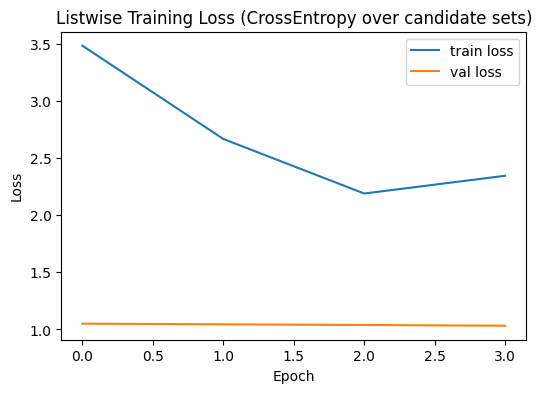

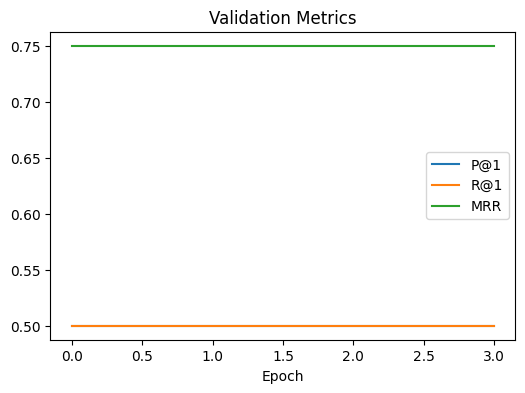

In [ ]:
# Visual: Training curves (4-panel)
fig, axes = plt.subplots(2, 2, figsize=(13, 9))
epochs_range = range(1, len(train_losses) + 1)

# Top-left: Loss curves
axes[0, 0].plot(epochs_range, train_losses, "o-", label="Train loss", color="#2563eb")
axes[0, 0].plot(epochs_range, val_losses, "s-", label="Val loss", color="#f59e0b")
axes[0, 0].axhline(avg_test_loss, ls="--", color="#10b981", alpha=0.7, label=f"Test loss ({avg_test_loss:.4f})")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Listwise CE Loss")
axes[0, 0].set_title("Loss Curves")
axes[0, 0].legend()

# Top-right: Validation metrics over epochs
axes[0, 1].plot(epochs_range, val_precisions, "o-", label="P@1", color="#2563eb")
axes[0, 1].plot(epochs_range, val_mrrs, "s-", label="MRR", color="#f59e0b")
axes[0, 1].axhline(test_p_at1, ls="--", color="#2563eb", alpha=0.4, label=f"Test P@1 ({test_p_at1:.3f})")
axes[0, 1].axhline(test_mrr, ls="--", color="#f59e0b", alpha=0.4, label=f"Test MRR ({test_mrr:.3f})")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Score")
axes[0, 1].set_title("Validation Metrics per Epoch")
axes[0, 1].set_ylim(0, 1.05)
axes[0, 1].legend(fontsize=8)

# Bottom-left: Train vs Val gap (overfitting indicator)
gap = [t - v for t, v in zip(train_losses, val_losses)]
colors_gap = ["#22c55e" if g <= 0 else "#ef4444" for g in gap]
axes[1, 0].bar(epochs_range, gap, color=colors_gap, edgecolor="white", width=0.6)
axes[1, 0].axhline(0, color="black", lw=0.5)
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Train Loss − Val Loss")
axes[1, 0].set_title("Overfitting Gap (red = train < val)")

# Bottom-right: Final summary card
axes[1, 1].axis("off")
summary = (
    f"Training Summary\n"
    f"{'─'*30}\n"
    f"Epochs trained:    {len(train_losses)}\n"
    f"Best val loss:     {best_val_loss:.4f}\n"
    f"{'─'*30}\n"
    f"Test Loss:   {avg_test_loss:.4f}\n"
    f"Test P@1:    {test_p_at1:.3f}\n"
    f"Test MRR:    {test_mrr:.3f}\n"
    f"{'─'*30}\n"
    f"Model params:    {sum(p.numel() for p in model.parameters()):,}\n"
    f"TF-IDF vocab:    {VOCAB_SIZE:,}\n"
    f"Train episodes:  {len(episodes_train):,}\n"
    f"Device:          {device}"
)
axes[1, 1].text(0.1, 0.5, summary, transform=axes[1, 1].transAxes,
                fontsize=11, fontfamily="monospace", verticalalignment="center",
                bbox=dict(boxstyle="round,pad=0.5", facecolor="#f0f4f8", edgecolor="#cbd5e1"))

plt.tight_layout()
plt.show()

In [ ]:
# Visual: Score distribution and rank analysis on test set
model.eval()
all_pos_scores, all_neg_scores = [], []
all_ranks = []
all_rules = []

with torch.no_grad():
    for ep in episodes_test:
        q = ep["query_row"]
        c = ep["candidates_df"]
        
        vec_q, scal_q, vec_C, scal_C, pair_C, pos_ix = vectorize_episode(
            q, c, vectorizer=vectorizer, amount_col=AMOUNT_COL,
            date_cols=DATE_COLS, ref_col=REF_COL,
        )
        
        K = vec_C.shape[0]
        t_a = torch.from_numpy(np.repeat(vec_q[None, :], K, axis=0)).to(device)
        s_a = torch.from_numpy(np.repeat(scal_q[None, :], K, axis=0)).to(device)
        t_b = torch.from_numpy(vec_C).to(device)
        s_b = torch.from_numpy(scal_C).to(device)
        pf = torch.from_numpy(pair_C).to(device)
        
        logits = model(t_a, s_a, t_b, s_b, pf).squeeze(-1)
        scores = logits.cpu().numpy()
        
        all_pos_scores.append(scores[0])
        all_neg_scores.extend(scores[1:].tolist())
        
        rank = int((np.argsort(-scores) == 0).argmax())
        all_ranks.append(rank + 1)  # 1-indexed
        all_rules.append(ep.get("rule", "UNKNOWN"))

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Left: Score distribution
axes[0].hist(all_neg_scores, bins=40, alpha=0.6, label=f"Negatives (n={len(all_neg_scores):,})", color="#ef4444", density=True)
axes[0].hist(all_pos_scores, bins=40, alpha=0.7, label=f"Positives (n={len(all_pos_scores):,})", color="#22c55e", density=True)
axes[0].set_xlabel("Raw Logit Score")
axes[0].set_ylabel("Density")
axes[0].set_title("Model Score Distribution (Test)")
axes[0].legend()

# Middle: Rank distribution
rank_counts = pd.Series(all_ranks).value_counts().sort_index()
colors_rank = ["#22c55e" if r == 1 else "#f59e0b" if r <= 3 else "#ef4444" for r in rank_counts.index]
axes[1].bar(rank_counts.index, rank_counts.values, color=colors_rank, edgecolor="white")
axes[1].set_xlabel("Rank of Correct Match")
axes[1].set_ylabel("Episodes")
axes[1].set_title("Where Does the Correct Match Rank? (Test)")
axes[1].set_xticks(rank_counts.index)

# Right: P@1 per rule
rule_df = pd.DataFrame({"rule": all_rules, "rank": all_ranks})
rule_df["hit"] = (rule_df["rank"] == 1).astype(int)
per_rule = rule_df.groupby("rule").agg(
    p_at_1=("hit", "mean"),
    count=("hit", "count")
).sort_values("p_at_1", ascending=True)

bars = axes[2].barh(per_rule.index, per_rule["p_at_1"], color="#4a90d9", edgecolor="white")
for i, (p, n) in enumerate(zip(per_rule["p_at_1"], per_rule["count"])):
    axes[2].text(p + 0.02, i, f"{p:.0%} (n={n})", va="center", fontsize=9)
axes[2].set_xlabel("P@1")
axes[2].set_xlim(0, 1.3)
axes[2].set_title("P@1 by Match Rule (Test)")

plt.tight_layout()
plt.show()

print(f"\nTest Rank Distribution:")
for r in sorted(rank_counts.index):
    pct = 100 * rank_counts[r] / len(all_ranks)
    print(f"  Rank {r}: {rank_counts[r]} episodes ({pct:.1f}%)")